In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from PIL import Image

Para responder a la pregunta "¿Existe una manera de caracterizar los lugares más recurrentes para inicio/fin de viaje?" que nos planteamos en un inicio, vamos a abordar el analisis de los lugares de pick-up y drop-off con un Heatmap (kdeplot) para visualizar de forma grafica los lugares con mayor frecuencia en el mapa de Nueva York.

In [2]:
# Importamos nuestro dataset luego de hacer un tratamiento de valores nulos 
DATASET_PATH = '../data/null_filtered_sampled_data.parquet'
# Importamos un dataset que contiene, por cada fila, el código de zona y las coordenadas (latitud y longitud)
GEO_DATASET_PATH = '../data/NYC_Taxi_Zones_Centroids_ObjectID.csv'

In [3]:
raw_df =  pd.read_parquet(DATASET_PATH)
df = pd.read_csv(GEO_DATASET_PATH)

In [ ]:
raw_df.describe()

In [ ]:
df.head()

Creamos un diccionario que mapea los nombres de los distritos de Nueva York con los respectivos codigos de zonas que los contienen. Ademas declaramos una funcion que, dado un codigo de zona, retorna el nombre del distrito.

In [4]:
zone_dicctionary = {
    "bronx": [199, 168, 126, 213, 208, 159, 147, 247, 69, 167, 212, 250, 58, 46, 119, 47, 59, 60, 248, 182, 183, 235, 169, 136, 94, 20, 31, 242, 220, 241, 18, 174, 32, 3, 51, 200, 240, 254, 81, 184, 259],
    "brooklyn": [55, 29, 150, 154, 108, 210, 21, 123, 149, 155, 11, 22, 178, 165, 91, 39, 67, 26, 89, 71, 72, 133, 222, 76, 14, 227, 111, 257, 190, 188, 85, 35, 77, 228, 181, 62, 61, 177, 63, 106, 189, 225, 37, 36, 17, 217, 256, 255, 112, 80, 49, 97, 34, 25, 65, 66, 195, 40, 54, 52, 33],
    "manhattan": [103, 104, 105, 12, 88, 87, 261, 13, 209, 45, 231, 232, 148, 144, 211, 125, 4, 79, 114, 113, 249, 158, 224, 107, 234, 90, 68, 246, 137, 164, 186, 100, 170, 233, 229, 162, 161, 230, 48, 50, 163, 202, 140, 141, 237, 142, 143, 262, 263, 236, 43, 239, 194, 75, 238, 151, 74, 41, 166, 42, 152, 116, 244, 120, 243, 127, 128, 153],
    "queens": [2, 30, 27, 201, 117, 86, 132, 124, 203, 180, 216, 10, 218, 219, 139, 38, 205, 215, 258, 197, 130, 122, 191, 96, 134, 28, 131, 102, 19, 101, 198, 160, 95, 135, 121, 98, 175, 64, 157, 196, 93, 192, 9, 16, 253, 92, 73, 171, 15, 53, 252, 57, 56, 173, 83, 82, 70, 129, 138, 226, 260, 207, 7, 223, 8, 146, 193, 179, 145],
    "staten_island": [44, 204, 84, 5, 109, 110, 99, 118, 176, 172, 214, 23, 6, 221, 115, 251, 156, 187, 245, 206]
}

In [5]:
def idToZone(id):
    for zone, ids in zone_dicctionary.items():
        if (id in ids):
            return zone
    return 'unkown'

Definimos tambien un diccionario con las coordenadas del centroide de cada distrito de Nueva York:

In [6]:
zone_coordinates_dic = {
    "bronx": [40.866691, -73.877673],
    "brooklyn": [40.650336, -73.945012],
    "manhattan": [40.777663, -73.970815],
    "queens": [40.720672, -73.803229],
    "staten_island": [40.584828, -74.147520]
}

zone_coordinates = pd.DataFrame([{"zone": zone, "zone_lat": coords[0], "zone_lon": coords[1]} for zone, coords in zone_coordinates_dic.items()])

In [ ]:
zone_coordinates.head()

Filtramos por separado los años 2019 y 2020 para hacer una comparativa y observar si hubo un cambio en el comportamiento de picku-up o drop-off zones. Luego, calculamos la frecuencia absoluta para cada codigo de zona y unimos este dataframe al de los datos de coordenadas. 

In [7]:
mask_2019 = raw_df.year == 2019
mask_2020 = raw_df.year == 2020

In [8]:
# Calculamos las frecuencias absolutas para la columna de pick-up
pickup_count_2019 = raw_df[mask_2019]["PULocationID"].value_counts()
pickup_count_2020 = raw_df[mask_2020]["PULocationID"].value_counts()

#Transformamos de tipo Series a DataFrame
pickup_count_2019 = pd.DataFrame([{"objectid": zone, "pickup_count": count} for zone, count in pickup_count_2019.items()])
pickup_count_2020 = pd.DataFrame([{"objectid": zone, "pickup_count": count} for zone, count in pickup_count_2020.items()])

# Calculamos las frecuencias absolutas para la columna de drop-off
dropoff_count_2019 = raw_df[mask_2019]["DOLocationID"].value_counts()
dropoff_count_2020 = raw_df[mask_2020]["DOLocationID"].value_counts()

#Transformamos de tipo Series a DataFrame
dropoff_count_2019 = pd.DataFrame([{"objectid": zone, "dropoff_count": count} for zone, count in dropoff_count_2019.items()])
dropoff_count_2020 = pd.DataFrame([{"objectid": zone, "dropoff_count": count} for zone, count in dropoff_count_2020.items()])

In [9]:
# Mergeamos los dataframe con las coordenadas de las zonas
df_2019 = df.merge(pickup_count_2019, on='objectid', how='inner').merge(dropoff_count_2019, on='objectid', how='inner')
df_2020 = df.merge(pickup_count_2020, on='objectid', how='inner').merge(dropoff_count_2020, on='objectid', how='inner')

In [ ]:
df_2019.head()

In [ ]:
df_2020.head()

Ahora mapeados los valores objectid con la funcion `idToZone` y agregamos una nueva columna:

In [10]:
df_2019["zone"] = df_2019.objectid.apply(idToZone)
df_2020["zone"] = df_2020.objectid.apply(idToZone)

In [ ]:
df_2019.head()

In [ ]:
df_2020.head()

Nos deshacemos de la fila que tiene la etiqueta de zona `unkown` ya que son valores que no pertenecen a ningun distrito, con lo cual fueron mal cargados.

In [11]:
df_2019 = df_2019[~(df_2019.zone == "unkown")]
df_2020 = df_2020[~(df_2020.zone == "unkown")]

In [12]:
# Agregamos las coordenadas de los distritos
df_2019 = df_2019.merge(zone_coordinates, on="zone", how='inner')
df_2020 = df_2020.merge(zone_coordinates, on="zone", how='inner')

In [16]:
df_2019.head()

objectid  centroid_lon  centroid_lat  pickup_count  dropoff_count   zone  \
0         3    -73.847422     40.864474            24             86  bronx   
1        18    -73.890183     40.867682            46            150  bronx   
2        20    -73.885867     40.857780            28             86  bronx   
3        31    -73.875476     40.857747             5             50  bronx   
4        32    -73.864901     40.864002            54            114  bronx   

    zone_lat   zone_lon  
0  40.866691 -73.877673  
1  40.866691 -73.877673  
2  40.866691 -73.877673  
3  40.866691 -73.877673  
4  40.866691 -73.877673

In [ ]:
df_2020.head()

Con los dataframes de 2019 y 2020 ya creados, podemos comenzar con el armado del Heatmap

In [13]:
# Cargamos la imagen del mapa de Nueva York
ny_map = Image.open('../data/map.png')
# Creamos un diccionario con las coordenadas de los limites de la imagen
ny_image_boundaries_coordinates = {
    "left": -74.2676,
    "top": 40.9229,
    "right": -73.7080,
    "bottom": 40.4971
}

In [39]:
# Declaramos una funcion para crear el heatmap
from pandas import Series

def plot_heatmap(x: Series, y: Series, freq: Series, ax, title: str, image: Image, boundaries: dict, bw_adjust: int = 0.5):
    ax.imshow(image, extent=[boundaries["left"], boundaries["right"], boundaries["bottom"], boundaries["top"]])
    sns.kdeplot(
        x=x,
        y=y,
        weights=freq,
        cmap="coolwarm",
        fill=True,
        alpha=0.3,
        ax=ax,
        # Ajustamos este parametro para no tener
        # la funcion tan suavizada, ya que queremos
        # ver zonas con mayor frecuencia
        bw_adjust=bw_adjust
    )
    ax.set_xlim(boundaries["left"], boundaries["right"])
    ax.set_ylim(boundaries["bottom"], boundaries["top"])
    ax.grid(False)
    ax.set_title(title)

Creamos los graficos de pick-up zones entre 2019 y 2020:

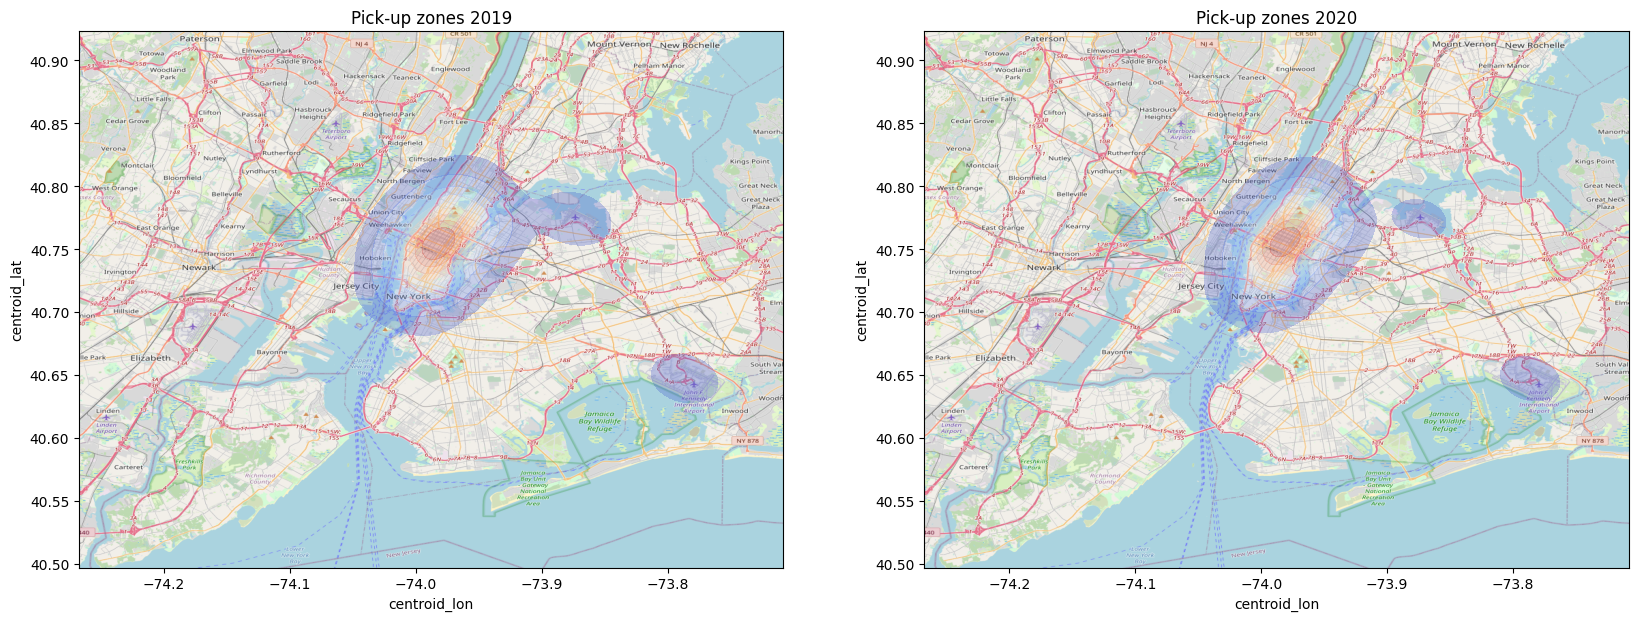

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    df_2019['centroid_lon'],
    df_2019['centroid_lat'],
    df_2019['pickup_count'],
    axs[0],
    "Pick-up zones 2019",
    ny_map,
    ny_image_boundaries_coordinates,
    0.9
)

plot_heatmap(
    df_2020['centroid_lon'],
    df_2020['centroid_lat'],
    df_2020['pickup_count'],
    axs[1],
    "Pick-up zones 2020",
    ny_map,
    ny_image_boundaries_coordinates,
    0.9
)

Probamos aplicando logaritmo a la columna count para ver si podemos apriciar una mejor variabilidad en los datos:

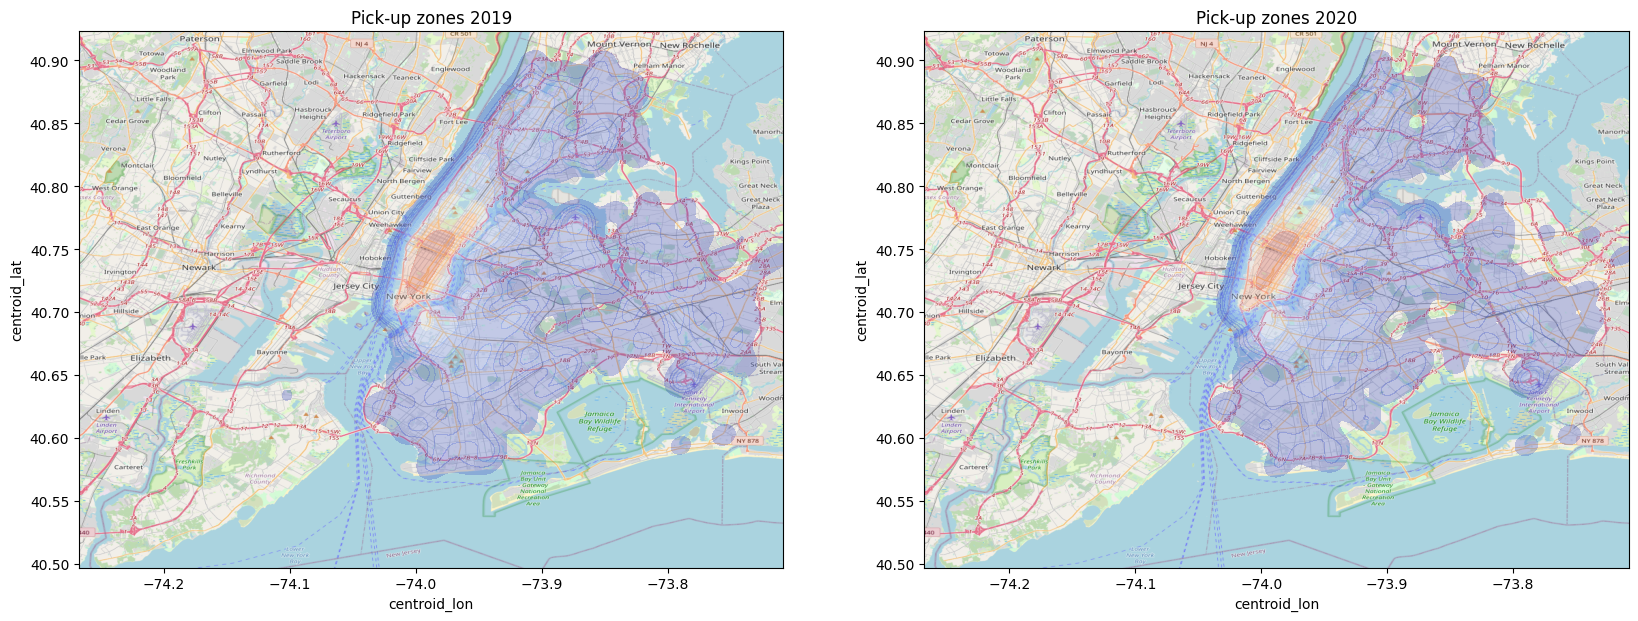

In [47]:
fig2, axs2 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    df_2019['centroid_lon'],
    df_2019['centroid_lat'],
    np.log(df_2019['pickup_count']),
    axs2[0],
    "Pick-up zones 2019",
    ny_map,
    ny_image_boundaries_coordinates,
    # Ajustamos el parametro bw_adjust
    0.3
)

plot_heatmap(
    df_2020['centroid_lon'],
    df_2020['centroid_lat'],
    np.log(df_2020['pickup_count']),
    axs2[1],
    "Pick-up zones 2020",
    ny_map,
    ny_image_boundaries_coordinates,
    0.3
)

En ambas versiones de los graficos, se puede apreciar una leve disminucion de las zonas de pick-up. Tambien se ve que la mayor concentracion de pick-up zones es en Manhattan.

Creamos los graficos de drop-off zones entre 2019 y 2020:

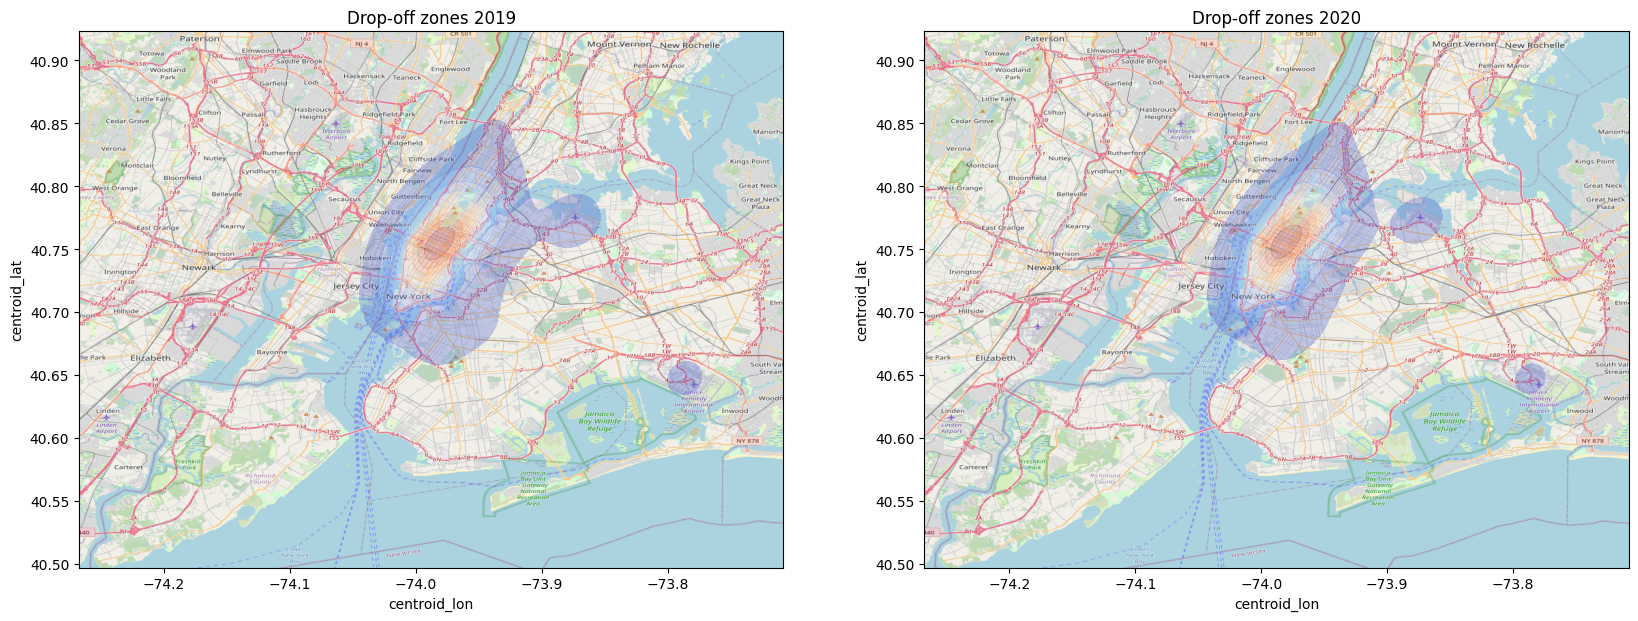

In [48]:
fig3, axs3 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    df_2019['centroid_lon'],
    df_2019['centroid_lat'],
    df_2019['dropoff_count'],
    axs3[0],
    "Drop-off zones 2019",
    ny_map,
    ny_image_boundaries_coordinates,
    0.9
)

plot_heatmap(
    df_2020['centroid_lon'],
    df_2020['centroid_lat'],
    df_2020['dropoff_count'],
    axs3[1],
    "Drop-off zones 2020",
    ny_map,
    ny_image_boundaries_coordinates,
    0.9
)

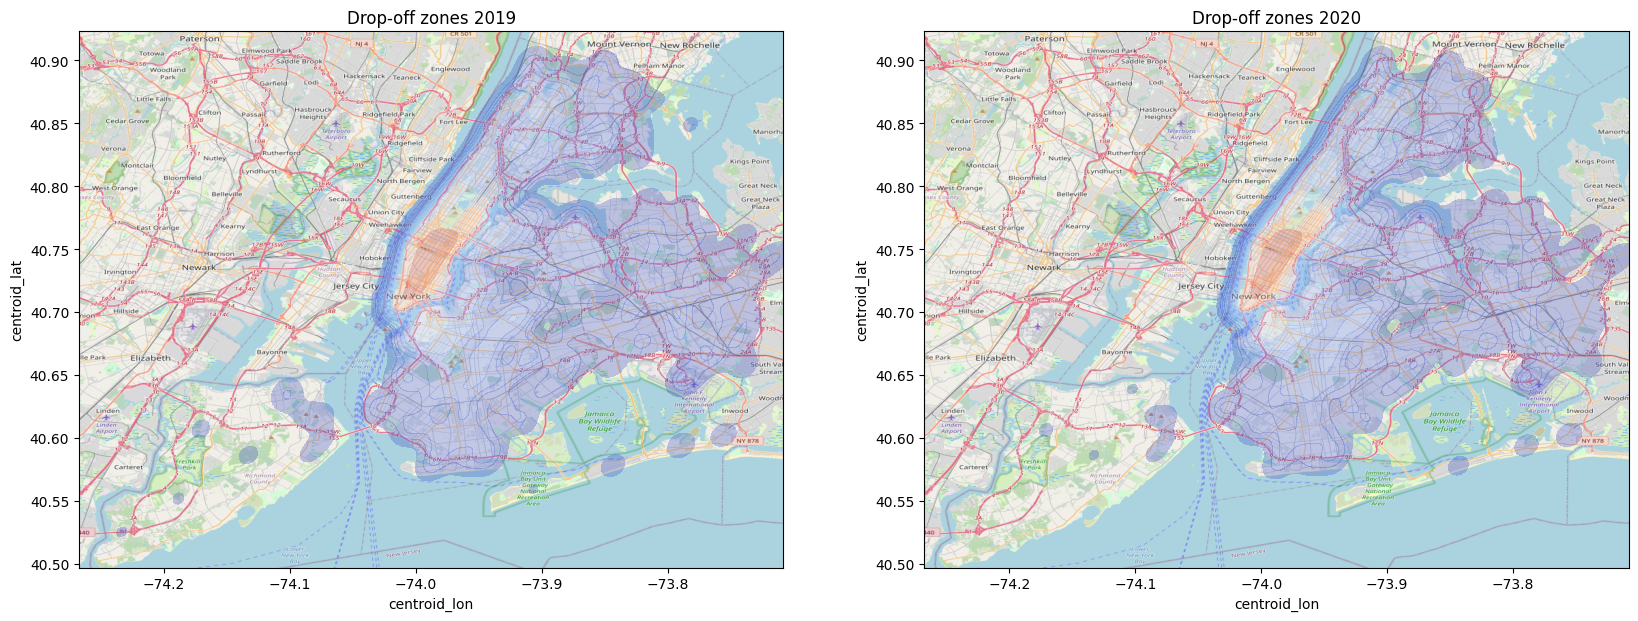

In [49]:
fig4, axs4 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    df_2019['centroid_lon'],
    df_2019['centroid_lat'],
    np.log(df_2019['dropoff_count']),
    axs4[0],
    "Drop-off zones 2019",
    ny_map,
    ny_image_boundaries_coordinates,
    0.3
)

plot_heatmap(
    df_2020['centroid_lon'],
    df_2020['centroid_lat'],
    np.log(df_2020['dropoff_count']),
    axs4[1],
    "Drop-off zones 2020",
    ny_map,
    ny_image_boundaries_coordinates,
    0.3
)

Al igual que en el grafico anterior, se puede apreciar una leve disminucion de las zonas de drop-off. Tambien se ve que la mayor concentracion de pick-up zones es en Manhattan. Ademas vemos que aparecen zonas que no estan en los datos de pick-up, como Staten Island.

Para reducir dimensionalidad sobre la variable categorica `PULocationID` y `DOLocationID`, ahora resumidas en `objectid`, vamos a agruparlas por distrito (`zone`), resultando solamente 5 categorias (Queen, Bronx, Manhattan, Staten Island y Brooklyn)

In [60]:
df_2019_by_neighborhood = df_2019.groupby("zone")[["pickup_count", "dropoff_count"]].sum().merge(zone_coordinates, on="zone", how="inner")
df_2020_by_neighborhood = df_2020.groupby("zone")[["pickup_count", "dropoff_count"]].sum().merge(zone_coordinates, on="zone", how="inner")

In [59]:
df_2019_by_neighborhood

zone  pickup_count  dropoff_count   zone_lat   zone_lon
0          bronx          2225           6014  40.866691 -73.877673
1       brooklyn         13442          47262  40.650336 -73.945012
2      manhattan        979052         957742  40.777663 -73.970815
3         queens         65178          45327  40.720672 -73.803229
4  staten_island            46            242  40.584828 -74.147520

In [61]:
df_2020_by_neighborhood

zone  pickup_count  dropoff_count   zone_lat   zone_lon
0          bronx           507           2654  40.866691 -73.877673
1       brooklyn          5728          26392  40.650336 -73.945012
2      manhattan        632164         614243  40.777663 -73.970815
3         queens         32341          25374  40.720672 -73.803229
4  staten_island            24            100  40.584828 -74.147520

Graficamos las pick-up y drop-off zones agrupadas:

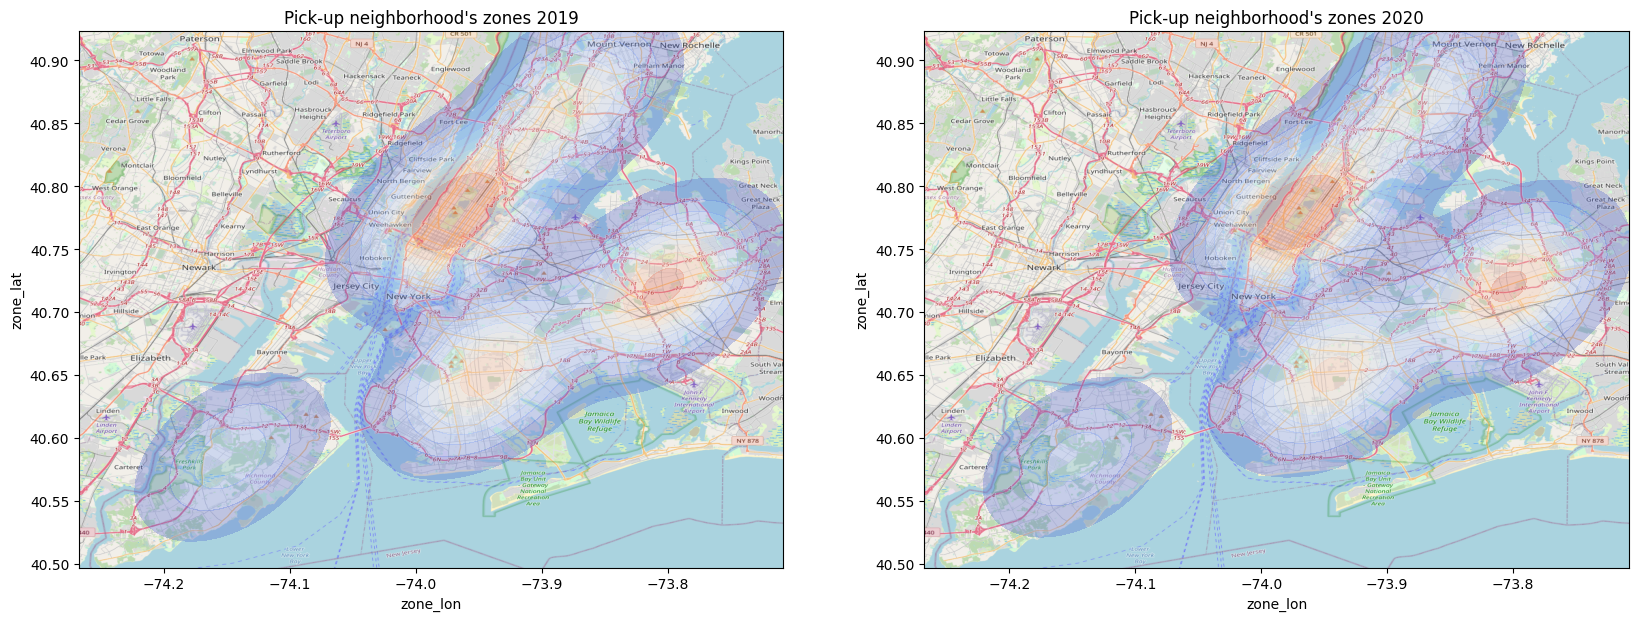

In [67]:
fig5, axs5 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    df_2019_by_neighborhood['zone_lon'],
    df_2019_by_neighborhood['zone_lat'],
    np.log(df_2019_by_neighborhood['pickup_count']),
    axs5[0],
    "Pick-up neighborhood's zones 2019",
    ny_map,
    ny_image_boundaries_coordinates,
    0.5
)

plot_heatmap(
    df_2020_by_neighborhood['zone_lon'],
    df_2020_by_neighborhood['zone_lat'],
    np.log(df_2020_by_neighborhood['pickup_count']),
    axs5[1],
    "Pick-up neighborhood's zones 2020",
    ny_map,
    ny_image_boundaries_coordinates,
    0.5
)

Al agrupar por distritos, vemos que ademas de Manhattan, Queens y Brooklyn tienen mas participacion en los viajes. En contraste, Staten Island y Bronx tienen menos frecuencia.

Ahora vamos a analizar que sucede particularmente en el distrito de Manhattan. Para ello vamos a cargar un mapa de Manhattan y filtrar los datos por `zone`.

In [70]:
# Cargamos la imagen del mapa de Manhattan
manhattan_map = Image.open('../data/manhattan-map.png')
# Creamos un diccionario con las coordenadas de los limites de la imagen
manhattan_image_boundaries_coordinates = {
    "left": -74.0242,
    "top": 40.8806,
    "right": -73.9050,
    "bottom": 40.6970
}

In [69]:
manhattan_2019_df = df_2019[df_2019.zone == 'manhattan']
manhattan_2020_df = df_2020[df_2020.zone == 'manhattan']

Graficamos los Pick-up zones

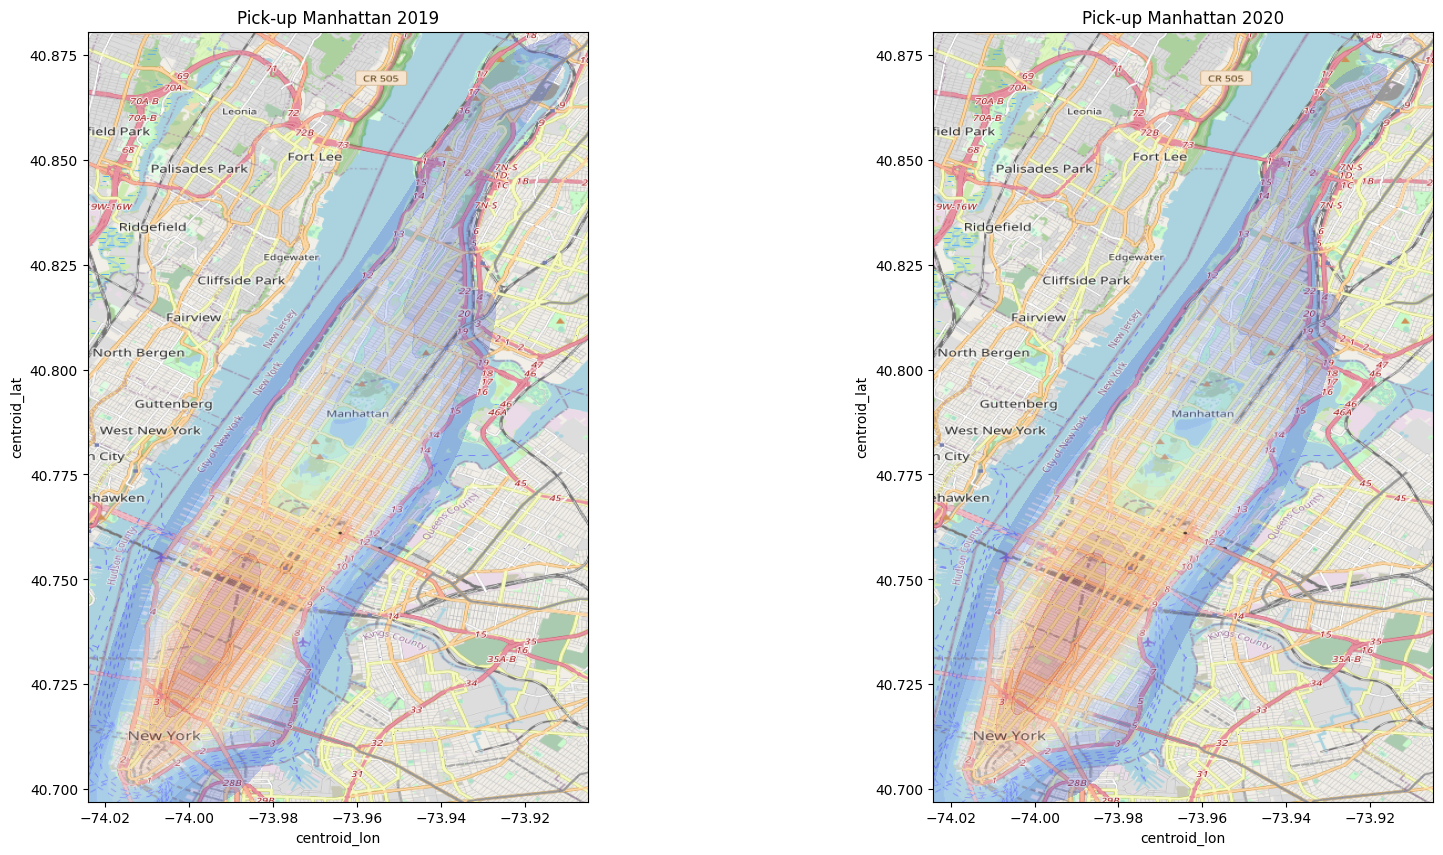

In [80]:
fig6, axs6 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    manhattan_2019_df['centroid_lon'],
    manhattan_2019_df['centroid_lat'],
    np.log(manhattan_2019_df['pickup_count']),
    axs6[0],
    "Pick-up Manhattan 2019",
    manhattan_map,
    manhattan_image_boundaries_coordinates,
    0.8
)

plot_heatmap(
    manhattan_2020_df['centroid_lon'],
    manhattan_2020_df['centroid_lat'],
    np.log(manhattan_2020_df['pickup_count']),
    axs6[1],
    "Pick-up Manhattan 2020",
    manhattan_map,
    manhattan_image_boundaries_coordinates,
    0.8
)

Graficamos los Drop-off zones:

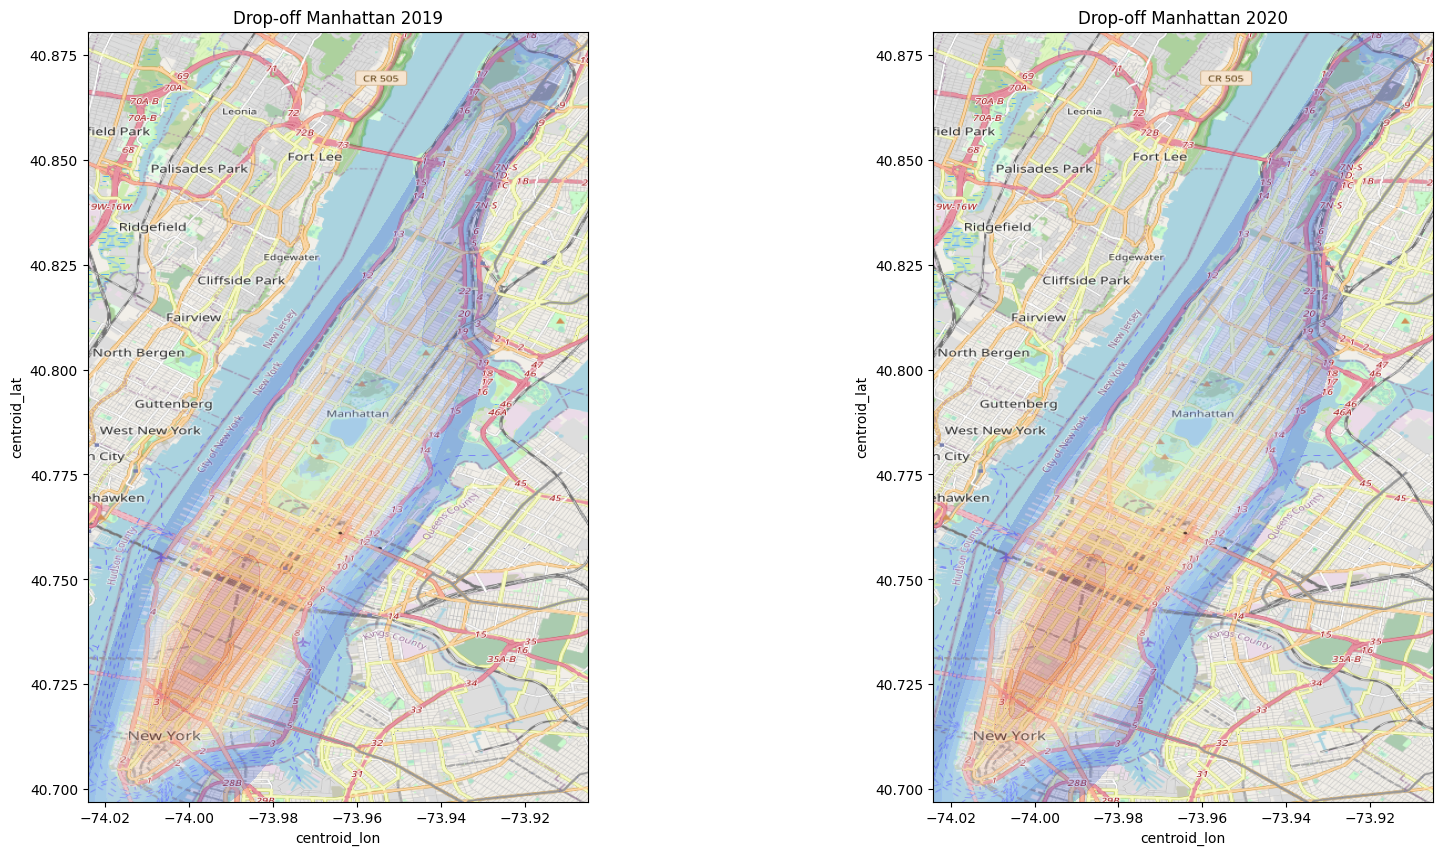

In [81]:
fig7, axs7 = plt.subplots(1, 2, figsize=(20, 10))  # 1 fila, 2 columnas

plot_heatmap(
    manhattan_2019_df['centroid_lon'],
    manhattan_2019_df['centroid_lat'],
    np.log(manhattan_2019_df['dropoff_count']),
    axs7[0],
    "Drop-off Manhattan 2019",
    manhattan_map,
    manhattan_image_boundaries_coordinates,
    0.8
)

plot_heatmap(
    manhattan_2020_df['centroid_lon'],
    manhattan_2020_df['centroid_lat'],
    np.log(manhattan_2020_df['dropoff_count']),
    axs7[1],
    "Drop-off Manhattan 2020",
    manhattan_map,
    manhattan_image_boundaries_coordinates,
    0.8
)

No se aprecian diferencias significativas entre 2019 y 2020 para el distrito de Manhattan.

## Conclusiones

- En primera instancia, se observaron mayor frecuencia de zonas de viaje sobre Manhattan y dos zonas aeroportuarias.
- Al aplicar logaritmo sobre las frecuencias, se observo una mejor distribucion de los datos sobre Manhattan, Queens, Brooklyn y Bronx. Siendo Mahattan el que mayor cantidad de viajes tiene.
- Al agrupar por distritos, se observa que los distritos de Queens y Brooklyn comienzan a contribuir como zonas de frecuencia media de viaje. Bronx y Staten Island parecen ser las zonas con menor frecuencia de viajes en Taxi.
- En todos los casos, Manhattan el la zona de mayor frecuencia de viajes.